# 批量归一化从零开始实现

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X,gamma,beta,moving_mean,moving_var ,eps,momentum):    #moving_mean,moving_var,近似全局的均值和方差，eps避免出零的变量,momentum更新mean和var的参数
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)            #推理环节使用全局的方差和均值
    else:                                                                   #接下来就开始作训练
        assert len(X.shape) in (2,4)                                        #输入只针对全连接（2d）和卷积(4d)
        if len(X.shape) == 2:                                               #当为全连接2d时，0维是batchsize， 1维是特征列向量
            mean = X.mean(dim=0)                                            #按行求均值，对每一列计算均值，结果 1* n的行向量        
            var = ((X-mean)**2).mean(dim=0)                                 #方差也是一个行向量， 全连接层就为按特征求取均值和方差
        else:                                                               #4d卷积情况,0维batch,1维通道数，2高，3宽
            mean = X.mean(dim=(0,2,3),keepdim=True)                         # 对每一个通道的所有批量，所有高宽来求均值，结果1*n*1*1的4d张量
            var = ((X-mean)**2).mean(dim=(0,2,3),keepdim=True)             #同样求取方差
        X_hat = (X -mean) / torch.sqrt(var+ eps)                            #var是方差平方，前面没开根号，
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y,moving_mean.data,moving_var.data

## 创建一个BatchNorm层

In [19]:
class BatchNorm(nn.Module):
    def __init__(self,num_features,num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1,num_features)
        else:
            shape = (1,num_features,1,1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        
    def forward(self,X):
        if self.moving_mean.device != X.device:                #挪参数到相同设备
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y,self.moving_mean,self.moving_var = batch_norm(X,self.gamma,self.beta,self.moving_mean,self.moving_var,eps=1e-5,momentum=0.9)
        return Y

应用BatchNorm 于LeNet模型

In [20]:
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),BatchNorm(6,num_dims=4),
    nn.Sigmoid(),nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),BatchNorm(16,num_dims=4),
    nn.Sigmoid(),nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),nn.Linear(16*4*4,120),
    BatchNorm(120,num_dims=2),nn.Sigmoid(),
    nn.Linear(120,84),BatchNorm(84,num_dims=2),
    nn.Sigmoid(),nn.Linear(84,10)    
)

在Fashion_MNIST数据集上训练网络

loss 0.247, train acc 0.909, test acc 0.765
38999.3 examples/sec on cuda:0


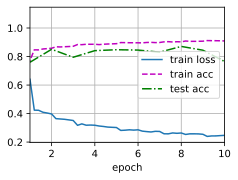

In [21]:
lr,num_epochs,batch_size = 1.0 ,10 ,256
train_iter , test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

查看gamma和便宜参数beta

In [22]:
net[1].gamma.reshape((-1,)),net[1].beta.reshape((-1,))

(tensor([1.0353, 3.0828, 1.6556, 1.9210, 1.1108, 1.8548], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-0.8872,  2.0513, -1.6089, -0.2524,  0.0037, -0.2097], device='cuda:0',
        grad_fn=<ViewBackward>))

调包实现

In [24]:
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),nn.BatchNorm2d(6),
    nn.Sigmoid(),nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.BatchNorm2d(16),
    nn.Sigmoid(),nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),nn.Linear(16*4*4,120),
    nn.BatchNorm1d(120),nn.Sigmoid(),
    nn.Linear(120,84),nn.BatchNorm1d(84),
    nn.Sigmoid(),nn.Linear(84,10)    
)

loss 0.255, train acc 0.907, test acc 0.833
52841.5 examples/sec on cuda:0


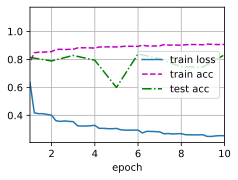

In [25]:
lr,num_epochs,batch_size = 1.0 ,10 ,256
train_iter , test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())